# FIT5196 Assessment 2

Student Name: Juan Pablo Grimaldi
Student ID: 32980523

Date: 31 August 2022


Environment: Python 3.9

Libraries used:
* os (for interacting with the operating system, included in Python 3.xxx package) 
* re (for regular expression, installed and imported) 
* pandas (for data manipulation)

-------------------------------------

# Table of Contents


[1. Introduction](#Intro) <br>
[2. Importing Libraries](#libs) <br>
[3. Examining Review Files](#examine) <br>
[4. Loading and Parsing Files](#load) <br>
$\;\;\;\;$[4.1. Defining Regular Expressions](#Reg_Exp) <br>
$\;\;\;\;$[4.2. Extract Information](#Read) <br>
$\;\;\;\;$[4.3. Structure results and data export](#structure) <br>
$\;\;\;\;$[4.4. Debugging](#debugging) <br>
[5. Writing Output to CSV File](#write) <br>
$\;\;\;\;$[5.1. Verification - using the sample files](#test) <br>
[6. Summary](#summary) <br>
[7. References](#Ref) <br>

-------------------------------------

## Introduction  <a class="anchor" name="Intro"></a>

In the real world, it's unlikely to have the good fortune of working with perfectly clean data.
Most often than not, data scientists will run into data sets that require some attention before
the analysis can even begin. For example, it's common in domains like Finance to observe outliers
 within stock returns that would create a biased set of estimates when creating the models.

George Box famously said:

> “All models are wrong, but some are useful.”

This reveals that data cleaning is indeed a key part of the process of data analysis, and
this assessment will cover common issues and solutions of working with data.

### Assessment Specifications

For this project, we will use and examine three data sets where each one of them contains a
problem to be resolved:

* `32980523_dirty_data.csv`: detect and fix errors.
* `32980523_outlier_data.csv`: detect and remove outlier rows (to be found w.r.t delivery_fee
attribute).
* `32980523_missing_data.csv`: impute the missing values.

In addition, there are three auxiliary files to be used during parts of the data cleaning process: `branches.csv`,`edges.csv`,`nodes.csv`.
<br>
The dataset contains Food Delivery data from a restaurant in Melbourne, Australia. The restaurant has three branches around CBD area. All three branches share the same menu but they have different management so they operate differently.
<br>
Below are the variables contained in the data sets:
<br>
* `order_id`: A unique id for each order
* `date`: The date the order was made, given in YYYY-MM-DD format
* `time`: The time the order was made, given in hh:mm:ss format
* `order_type`: A categorical attribute representing the different types of orders namely: Breakfast, Lunch or Dinner
* `branch_code`: A categorical attribute representing the branch code in which the order was made. Branch information is given in the branches.csv file.
* `order_items`: A list of tuples representing the order items: first element of the tuple is the
item ordered, and the second element is the quantity ordered for that item.
* `order_price`: A float value representing the order total price.
* `customer_lat`: Latitude of the customer coming from the nodes.csv file.
* `customer_lon`: Longitude of the customer coming from the nodes.csv file.
* `customerHasloyalty?`: A logical variable denoting whether the customer has a loyalty card with
the restaurant (1 if the customer has loyalty and 0 otherwise).
* `distance_to_customer_KM`: A float representing the shortest distance, in kilometers, between the branch and the customer nodes with respect to the nodes.csv and the edges.csv files.
* `delivery_fee`: A float representing the delivery fee of the order.


### Additional Information

The following helpful details are also provided in the brief:

* There are three types of meals:
    * Breakfast - served during morning (8am - 12pm),
    * Lunch - served during afternoon (12:00:01pm - 4pm)
    * Dinner - served during evening (4:00:01pm - 8pm)

* Each meal has a distinct set of items in the menu (ex: breakfast items can't be served during lunch or dinner and so on).

* A useful python package to solve a linear system of equations is numpy.linalg

* Delivery fee is calculated using a different method for each branch. The fee depends linearly (but in different ways for each branch) on:
    1. weekend or weekday (1 or 0) - as a binary variable
    2. time of the day (morning 0, afternoon 1, evening 2) - as a categorical variable
    3. distance between branch and customer

* **If a customer has loyalty, they get a 50% discount on delivery fee**

* The restaurant uses Djikstra algorithm to calculate the shortest distance between customer and restaurant. (explore networkx python package for this or alternatively find a way to implement the algorithm yourself)

* We know that the below columns are error-free:
    * order_id
    * time
    * the numeric quantity in order_items

-------------------------------------

## Enviroment Preparation  <a class="anchor" name="libs"></a>

The packages to be used in this assessment are imported in the following. They are used to fulfill the following tasks:

* **pandas:** to structure the results into a tabular format, as per the assessment requirements.
* **matplotlib:** for visual exploratory data analysis.
* **missingno:** to process and visualise missing data.

In [273]:
import datetime

# import libraries to be used in the assignment
#Basic scientific python libs
import pandas as pd
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
# Configure visualisations
%matplotlib inline
# to make things pretty
mpl.style.use( 'ggplot' )

-------------------------------------

## Load and Examine Datasets <a class="anchor" name="examine"></a>

<br>Most of the exploratory data analysis will be performed with methods from the `pandas` library.
To begin the process, all the csv files will be read into a dataframe:


In [274]:
#load datasets
dirty_data = pd.read_csv("data/32980523_dirty_data.csv")
missing_data = pd.read_csv("data/32980523_missing_data.csv")
outlier_data = pd.read_csv("data/32980523_outlier_data.csv")

The following sections will cover the process of review and amendment of each of the datasets.

### Dirty Data

Firstly, we will use the info() method to review the variably types within the dataset and print
the data set size.

In [275]:
# review dirty data variable types
print("---- Dirty Data: data types ----")
dirty_data.info()
print("---- Dirty Data: data frame size ----")
dirty_data.shape

---- Dirty Data: data types ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             500 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB
---- Dirty Data: data frame size ----


(500, 12)

Next, the head and tail methods from pandas will allow a quick overview of the dataframe structure.

In [276]:
#inspect dirty data head
dirty_data.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDJ06243,2021-11-02,18:08:27,Dinner,TP,"[('Salmon', 4), ('Pasta', 2), ('Fish&Chips', 1...",308.0,-37.806521,144.944874,0,10.082,13.802598
1,ORDA10907,2021-11-03,18:08:27,Dinner,BK,"[('Salmon', 5), ('Pasta', 5)]",342.5,-37.810712,144.946133,0,9.145,16.150990
2,ORDA06776,2021-08-14,15:26:11,Lunch,BK,"[('Fries', 1), ('Salad', 7), ('Chicken', 2), (...",320.4,-37.819004,144.954318,0,8.676,16.680944
3,ORDY05744,2021-10-26,17:48:10,Dinner,TP,"[('Salmon', 7), ('Pasta', 10), ('Shrimp', 5)]",832.0,-37.817244,144.967764,0,11.792,11.549074
4,ORDX00833,2021-05-05,12:03:22,Lunch,BK,"[('Salad', 2), ('Steak', 10), ('Chicken', 2), ...",892.4,-37.809557,144.972643,0,6.714,12.512411


In [277]:
#inspect dirty data head
dirty_data.tail()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
495,ORDX04741,2021-03-24,10:42:15,Breakfast,BK,"[('Coffee', 9), ('Pancake', 9)]",249.75,-37.806837,144.951380,0,8.581,13.103430
496,ORDJ05472,2021-10-03,17:07:36,Dinner,TP,"[('Pasta', 4), ('Fish&Chips', 7), ('Shrimp', 2)]",463.00,-37.807966,144.945429,0,9.956,15.517818
497,ORDK01012,2021-06-16,13:24:30,Lunch,BK,"[('Burger', 5), ('Chicken', 5), ('Fries', 10),...",600.40,-37.807797,144.973202,0,6.525,11.838280
498,ORDK04997,2021-03-16,10:21:58,Breakfast,BK,"[('Eggs', 8), ('Coffee', 2), ('Cereal', 3), ('...",283.50,-37.799207,144.961314,0,8.333,13.031216
499,ORDA02222,2021-04-27,11:53:14,Breakfast,BK,"[('Pancake', 7), ('Coffee', 1), ('Cereal', 8)]",321.25,-37.803561,144.918101,0,11.587,16.161815


In [278]:
# summarise numerical variables
dirty_data.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,481.516700,-35.379832,143.138468,0.066000,8.613976,13.669932
std,265.064722,19.355386,18.203815,0.248531,1.643464,2.392980
min,41.000000,-37.833333,-37.816142,0.000000,3.657000,5.218812
25%,276.812500,-37.819053,144.951689,0.000000,7.630750,12.589348
50%,436.600000,-37.812472,144.963557,0.000000,8.762500,13.921834
75%,656.075000,-37.805754,144.977142,0.000000,9.631000,15.094976
max,1432.000000,145.000032,145.017716,1.000000,16.698000,21.566636


#### Individual Variable Review

This section will cover the review of each one of the variables in the `dirty_data` dataframe.

#### Date

The following line of code should easily parse the date column into a proper pandas datetime format. However, there's a number of errors that pop up when running it that indicate a deeper review is required on each component of the date:

``` python
dirty_date = pd.to_datetime(dirty_data['date'], format ='%Y-%m-%d')
>>> "ValueError: time data 2021-30-08 doesn't match format specified"
```
We will use some basic regular expressions to extract the days, months and years from the `date` series. All common regular expression methods are available directly from pandas.

In [279]:
#years
years = ([itm[0][0] for itm in 
  dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
  if len(itm)>0])
years = pd.Series(years).apply(pd.to_numeric)
#months
months = ([itm[0][1] for itm in 
  dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
  if len(itm)>0])
months = pd.Series(months).apply(pd.to_numeric)
#days
days = ([itm[0][2] for itm in 
  dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
  if len(itm)>0])
days = pd.Series(days).apply(pd.to_numeric)
# concatenate series
date_concat = pd.concat([years,months,days], axis=1)
# assign names
date_concat.columns=['year','month','day']

In [280]:
# create max min average function
date_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    498 non-null    int64
 1   month   498 non-null    int64
 2   day     498 non-null    int64
dtypes: int64(3)
memory usage: 11.8 KB


In [281]:
date_concat.describe()

,year,month,day
count,498.0,498.000000,498.000000
mean,2021.0,6.670683,15.829317
std,0.0,3.825676,8.729156
min,2021.0,1.000000,1.000000
25%,2021.0,4.000000,8.000000
50%,2021.0,6.000000,16.500000
75%,2021.0,10.000000,23.000000
max,2021.0,30.000000,31.000000


We can immediately see observe two issues:

1. Two rows weren't properly parsed by the regex format, which should be inspected in further
detail.
2. It appears that some months are higher than the permitted range for a valid date (i.e. larger
than 12).

In [282]:
#check rows were the month is larger than 12.
date_concat[date_concat['month'] > 12]

,year,month,day
113,2021,30,8
170,2021,19,10
263,2021,30,6
416,2021,22,8


In [283]:
index = 0
for each in dirty_data['date']:
  #check for years outside 2021
  if each.split("-")[0] != "2021":
    print(f"index:{index}, value:{each}")
  #check for nun-numeric month
  elif not each.split("-")[1].isnumeric():
    print(f"index:{index}, value:{each}")
  index += 1

index:400, value:Tue Jun  1 00:00:00 2021
index:418, value:2021-Aug-03


In [284]:
# changing formats
# observation 400
dirty_data.at[400,'date'] = "2021-06-01"
# observation 418
dirty_data.at[418,'date'] = "2021-08-03"

In [285]:
# re-run date concat
#re run date concat
years = ([itm[0][0] for itm in
          dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
          if len(itm)>0])
years = pd.Series(years).apply(pd.to_numeric)
#months
months = ([itm[0][1] for itm in
           dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
           if len(itm)>0])
months = pd.Series(months).apply(pd.to_numeric)
#days
days = ([itm[0][2] for itm in
         dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
         if len(itm)>0])
days = pd.Series(days).apply(pd.to_numeric)
# concatenate series
date_concat = pd.concat([years,months,days], axis=1)
# assign names
date_concat.columns=['year','month','day']

In [286]:
date_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    500 non-null    int64
 1   month   500 non-null    int64
 2   day     500 non-null    int64
dtypes: int64(3)
memory usage: 11.8 KB


In [287]:
#check rows were the month is larger than 12.
date_concat[date_concat['month'] > 12]

,year,month,day
113,2021,30,8
170,2021,19,10
263,2021,30,6
417,2021,22,8


We will impute the incorrect months with proper months:

In [288]:
# most common month
date_concat['month'].mode()

0    6
Name: month, dtype: int64

In [289]:
# correct months
import numpy as np
date_concat['month'] = np.where(date_concat['month'] > 12, 6, date_concat['month'])

In [290]:
# add leading zeroes
date_concat['month'] = date_concat['month'].apply(lambda x: '{0:0>2}'.format(x))

In [291]:
date_concat['day'] = date_concat['day'].apply(lambda x: '{0:0>2}'.format(x))

In [292]:
# put all months together and
dirty_data['date'] = date_concat['year'].astype(str) + "-"+ date_concat['month'].astype(str) + \
                     "-" + date_concat['day'].astype(str)


In [293]:
dirty_data.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDJ06243,2021-11-02,18:08:27,Dinner,TP,"[('Salmon', 4), ('Pasta', 2), ('Fish&Chips', 1...",308.0,-37.806521,144.944874,0,10.082,13.802598
1,ORDA10907,2021-11-03,18:08:27,Dinner,BK,"[('Salmon', 5), ('Pasta', 5)]",342.5,-37.810712,144.946133,0,9.145,16.150990
2,ORDA06776,2021-08-14,15:26:11,Lunch,BK,"[('Fries', 1), ('Salad', 7), ('Chicken', 2), (...",320.4,-37.819004,144.954318,0,8.676,16.680944
3,ORDY05744,2021-10-26,17:48:10,Dinner,TP,"[('Salmon', 7), ('Pasta', 10), ('Shrimp', 5)]",832.0,-37.817244,144.967764,0,11.792,11.549074
4,ORDX00833,2021-05-05,12:03:22,Lunch,BK,"[('Salad', 2), ('Steak', 10), ('Chicken', 2), ...",892.4,-37.809557,144.972643,0,6.714,12.512411


#### Order Type

For order type, it will be important to take the following aspects into consideration:

* There are three types of meals:
    * Breakfast - served during morning (8am - 12pm),
    * Lunch - served during afternoon (12:00:01pm - 4pm)
    * Dinner - served during evening (4:00:01pm - 8pm)
* Each meal has a distinct set of items in the menu (ex: breakfast items can't be served during lunch or dinner and so on).


In [294]:
# check order types
dirty_data['order_type'].unique()

array(['Dinner', 'Lunch', 'Breakfast'], dtype=object)

In [295]:
dirty_data['time']

0      18:08:27
1      18:08:27
2      15:26:11
3      17:48:10
4      12:03:22
         ...   
495    10:42:15
496    17:07:36
497    13:24:30
498    10:21:58
499    11:53:14
Name: time, Length: 500, dtype: object

In [296]:
# transform time to timestamp format
dirty_data['time'] = pd.to_datetime(dirty_data['time'],format= '%H:%M:%S')

In [297]:
# create hour column
dirty_data['hour'] = dirty_data['time'].dt.hour
dirty_data['minute'] = dirty_data['time'].dt.minute
dirty_data['second'] = dirty_data['time'].dt.second

In [298]:
#create barplot
# dirty_data[['hour','minute','second','time','order_type']]

dirty_data[['order_type','hour','order_id']].groupby(['order_type','hour']).count()

order_id
order_type hour          
Breakfast  8           44
           9           39
           10          33
           11          29
           12           1
           14           1
Dinner     9            1
           16          36
           17          41
           18          44
           19          34
           20           6
Lunch      8            1
           10           1
           12          50
           13          59
           14          38
           15          42

In [299]:
# check 2 breakfast at 12 and 2
dirty_data[((dirty_data.hour == 12) | (dirty_data.hour == 14))  & (dirty_data.order_type ==
                                                                 "Breakfast")]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,hour,minute,second
227,ORDJ04089,2021-05-21,1900-01-01 12:33:48,Breakfast,TP,"[('Steak', 10), ('Chicken', 6)]",642.0,-37.813249,144.937156,0,10.529,13.214083,12,33,48
236,ORDJ06516,2021-07-17,1900-01-01 14:25:21,Breakfast,TP,"[('Salad', 2), ('Steak', 3), ('Fries', 2)]",193.4,-37.813381,144.973869,0,8.609,13.785865,14,25,21


The fix for these entries will be to swap the order type for Lunch.

In [300]:
# check 1 lunch at 10
dirty_data[(dirty_data.hour == 10)  & (dirty_data.order_type == "Lunch")]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,hour,minute,second
360,ORDK05672,2021-03-05,1900-01-01 10:01:41,Lunch,BK,"[('Eggs', 7), ('Cereal', 1), ('Coffee', 3)]",183.5,-37.822528,144.95032,0,9.042,14.153578,10,1,41


This entry needs to be changed to breakfast.

In [301]:
# check 1 diner at 9
dirty_data[(dirty_data.hour == 9)  & (dirty_data.order_type == "Dinner")]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,hour,minute,second
303,ORDA09446,2021-01-31,1900-01-01 09:00:50,Dinner,BK,"[('Coffee', 10), ('Cereal', 1), ('Pancake', 9)...",380.25,-37.798457,144.979611,0,6.97,14.257849,9,0,50


This entry needs to be changed to Breakfast.

#### Branch Code

<AxesSubplot:xlabel='branch_code'>

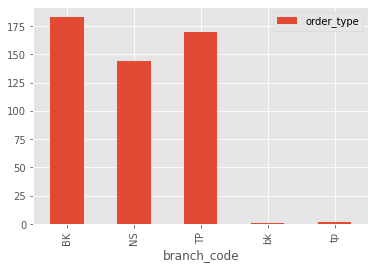

In [302]:
# fix casing 
dirty_data[['branch_code','order_type']].groupby('branch_code').count().plot(kind="bar")

There seems to be an issue with the casing of branch codes. The fix is straightforward:

In [303]:
dirty_data['branch_code'] = dirty_data['branch_code'].str.upper()

<AxesSubplot:xlabel='branch_code'>

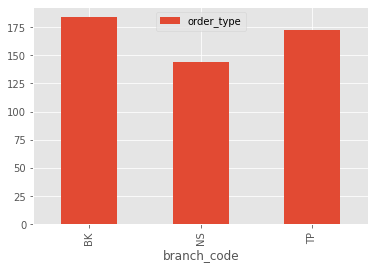

In [304]:
# re-check
dirty_data[['branch_code','order_type']].groupby('branch_code').count().plot(kind="bar")

#### Order items & Order Price

In [305]:
# steps to review


1. convert variable into list of tuples
2. figure out which items belong to which meal


In [306]:
# order items and order price
dirty_data_op = dirty_data[['order_items','order_price']]

In [307]:
import seaborn as sns
dirty_data_op

,order_items,order_price
0,"[('Salmon', 4), ('Pasta', 2), ('Fish&Chips', 1...",308.00
1,"[('Salmon', 5), ('Pasta', 5)]",342.50
2,"[('Fries', 1), ('Salad', 7), ('Chicken', 2), (...",320.40
3,"[('Salmon', 7), ('Pasta', 10), ('Shrimp', 5)]",832.00
4,"[('Salad', 2), ('Steak', 10), ('Chicken', 2), ...",892.40
...,...,...
495,"[('Coffee', 9), ('Pancake', 9)]",249.75
496,"[('Pasta', 4), ('Fish&Chips', 7), ('Shrimp', 2)]",463.00
497,"[('Burger', 5), ('Chicken', 5), ('Fries', 10),...",600.40
498,"[('Eggs', 8), ('Coffee', 2), ('Cereal', 3), ('...",283.50


One test would be to extract each item price from the order price and quantity

In [308]:
# each row can only have one anomaly!
dirty_data[dirty_data["order_type"]=="Breakfast"].head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,hour,minute,second
9,ORDC01599,2021-03-22,1900-01-01 10:32:06,Breakfast,NS,"[('Eggs', 6), ('Pancake', 10), ('Coffee', 4), ...",410.50,-37.807758,144.943627,0,9.186,14.823477,10,32,6
12,ORDI00267,2021-04-23,1900-01-01 11:43:05,Breakfast,NS,"[('Cereal', 10), ('Pancake', 8), ('Coffee', 1)]",383.50,-37.814318,144.949383,0,10.094,14.965101,11,43,5
14,ORDC00878,2021-02-11,1900-01-01 09:21:07,Breakfast,NS,"[('Coffee', 4), ('Cereal', 6), ('Pancake', 9),...",468.25,-37.820711,145.004950,0,10.748,15.569070,9,21,7
18,ORDX06107,2021-04-28,1900-01-01 11:53:14,Breakfast,BK,"[('Eggs', 6), ('Cereal', 10), ('Pancake', 2)]",370.50,-37.805997,144.929506,0,11.067,16.010717,11,53,14
19,ORDA07292,2021-04-08,1900-01-01 11:12:40,Breakfast,BK,"[('Eggs', 2), ('Cereal', 9), ('Coffee', 8), ('...",466.25,-37.822457,144.947848,0,9.255,14.132851,11,12,40


In [309]:
# ! this will likely be the most challenging column to check, as I may need to confirm that all prices are alright with a system of equations.

In [310]:
# some code

In [311]:
dirty_data.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,hour,minute,second
0,ORDJ06243,2021-11-02,1900-01-01 18:08:27,Dinner,TP,"[('Salmon', 4), ('Pasta', 2), ('Fish&Chips', 1...",308.0,-37.806521,144.944874,0,10.082,13.802598,18,8,27
1,ORDA10907,2021-11-03,1900-01-01 18:08:27,Dinner,BK,"[('Salmon', 5), ('Pasta', 5)]",342.5,-37.810712,144.946133,0,9.145,16.150990,18,8,27
2,ORDA06776,2021-08-14,1900-01-01 15:26:11,Lunch,BK,"[('Fries', 1), ('Salad', 7), ('Chicken', 2), (...",320.4,-37.819004,144.954318,0,8.676,16.680944,15,26,11
3,ORDY05744,2021-10-26,1900-01-01 17:48:10,Dinner,TP,"[('Salmon', 7), ('Pasta', 10), ('Shrimp', 5)]",832.0,-37.817244,144.967764,0,11.792,11.549074,17,48,10
4,ORDX00833,2021-05-05,1900-01-01 12:03:22,Lunch,BK,"[('Salad', 2), ('Steak', 10), ('Chicken', 2), ...",892.4,-37.809557,144.972643,0,6.714,12.512411,12,3,22


#### Customer location

In [312]:
# lets map!

In [313]:
import plotly.express as px

-------------------------------------

In [314]:
dirty_data

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,hour,minute,second
0,ORDJ06243,2021-11-02,1900-01-01 18:08:27,Dinner,TP,"[('Salmon', 4), ('Pasta', 2), ('Fish&Chips', 1...",308.00,-37.806521,144.944874,0,10.082,13.802598,18,8,27
1,ORDA10907,2021-11-03,1900-01-01 18:08:27,Dinner,BK,"[('Salmon', 5), ('Pasta', 5)]",342.50,-37.810712,144.946133,0,9.145,16.150990,18,8,27
2,ORDA06776,2021-08-14,1900-01-01 15:26:11,Lunch,BK,"[('Fries', 1), ('Salad', 7), ('Chicken', 2), (...",320.40,-37.819004,144.954318,0,8.676,16.680944,15,26,11
3,ORDY05744,2021-10-26,1900-01-01 17:48:10,Dinner,TP,"[('Salmon', 7), ('Pasta', 10), ('Shrimp', 5)]",832.00,-37.817244,144.967764,0,11.792,11.549074,17,48,10
4,ORDX00833,2021-05-05,1900-01-01 12:03:22,Lunch,BK,"[('Salad', 2), ('Steak', 10), ('Chicken', 2), ...",892.40,-37.809557,144.972643,0,6.714,12.512411,12,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORDX04741,2021-03-24,1900-01-01 10:42:15,Breakfast,BK,"[('Coffee', 9), ('Pancake', 9)]",249.75,-37.806837,144.951380,0,8.581,13.103430,10,42,15
496,ORDJ05472,2021-10-03,1900-01-01 17:07:36,Dinner,TP,"[('Pasta', 4), ('Fish&Chips', 7), ('Shrimp', 2)]",463.00,-37.807966,144.945429,0,9.956,15.517818,17,7,36
497,ORDK01012,2021-06-16,1900-01-01 13:24:30,Lunch,BK,"[('Burger', 5), ('Chicken', 5), ('Fries', 10),...",600.40,-37.807797,144.973202,0,6.525,11.838280,13,24,30
498,ORDK04997,2021-03-16,1900-01-01 10:21:58,Breakfast,BK,"[('Eggs', 8), ('Coffee', 2), ('Cereal', 3), ('...",283.50,-37.799207,144.961314,0,8.333,13.031216,10,21,58


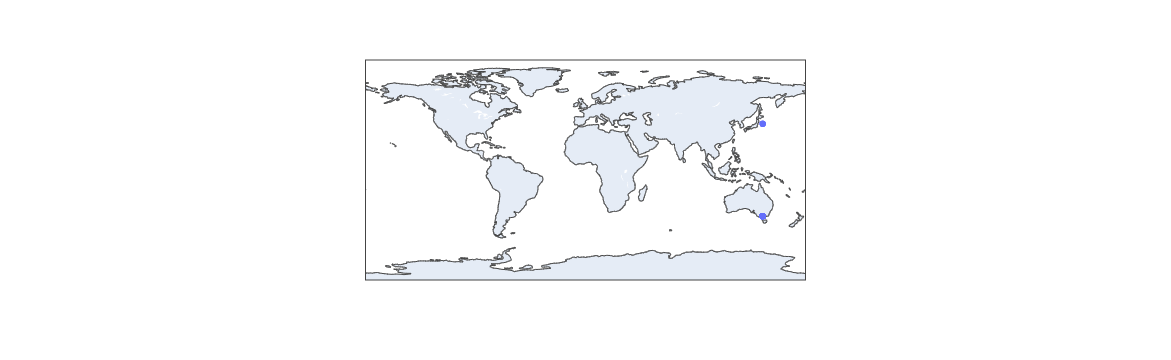

In [315]:
df = dirty_data[['customer_lon','customer_lat','order_price']]
fig = px.scatter_geo(df, lon='customer_lon',lat='customer_lat')
fig.show()
# ! need to zoom in, but there's clearly an error considering all customers are melb based.

In [316]:
#! need to reverse some of the minus for pluses and pluses for minus


#### Distance to Customer

This variable should hold a relationship within...

In [317]:
# use supplementary files
nodes = pd.read_csv('supplementary_files/nodes.csv')
edges = pd.read_csv('supplementary_files/edges.csv')
branches = pd.read_csv('supplementary_files/branches.csv')

In [318]:
nodes

,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817
3,711327760,-37.807885,144.957719
4,777781264,-37.805221,144.952173
...,...,...,...
17112,767688602,-37.804021,144.969444
17113,777781181,-37.805238,144.952321
17114,1449431614,-37.815345,144.974603
17115,1449431622,-37.815262,144.975149


In [319]:
edges

,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
0,0,711327755,711332946,58.0,1,15.0
1,2,711327755,55725841,15.0,2,20.0
2,3,711327755,711327760,165.0,1,15.0
3,4,711327756,703557073,4.0,0,10.0
4,5,711327756,711332946,8.0,1,15.0
...,...,...,...,...,...,...
42219,50006,1449431614,1449431244,16.0,2,20.0
42220,50007,1449431614,1449431574,17.0,2,20.0
42221,50008,1449431622,60095777,196.0,1,15.0
42222,50009,1449431623,1449431622,19.0,1,15.0


In [320]:
branches

,branch_code,branch_name,branch_lat,branch_lon
0,NS,Nickolson,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450


In [321]:
# merge nodes to branches, as it doesn't have it

#### Customer Loyalty

In [322]:
#### some code

### Missing Data

This section will review the `missing_data` data frame and will analise the integrity of the data based on its missigness.
<br>
A dataset missingess describes the type of missing information:
* Missing at random
* Missing completely at random
* Missing not at random

For this section we will use `pandas` as well as the `missigno` library to review the dataframe's
 missigness characteristics.

In [323]:
# note that missing data may be represented as something other than Nan and should be converted
# appropriately.

By using the info method from the `pandas` library we can concisely see the non-null counts for
each one of the variables in the dataset. As a result, we can see that `branch_code` as well as
`delivery_fee` have null values that require further inspection.

In [324]:
# test
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              450 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             400 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


Brief introduction of the dataset.

<AxesSubplot:>

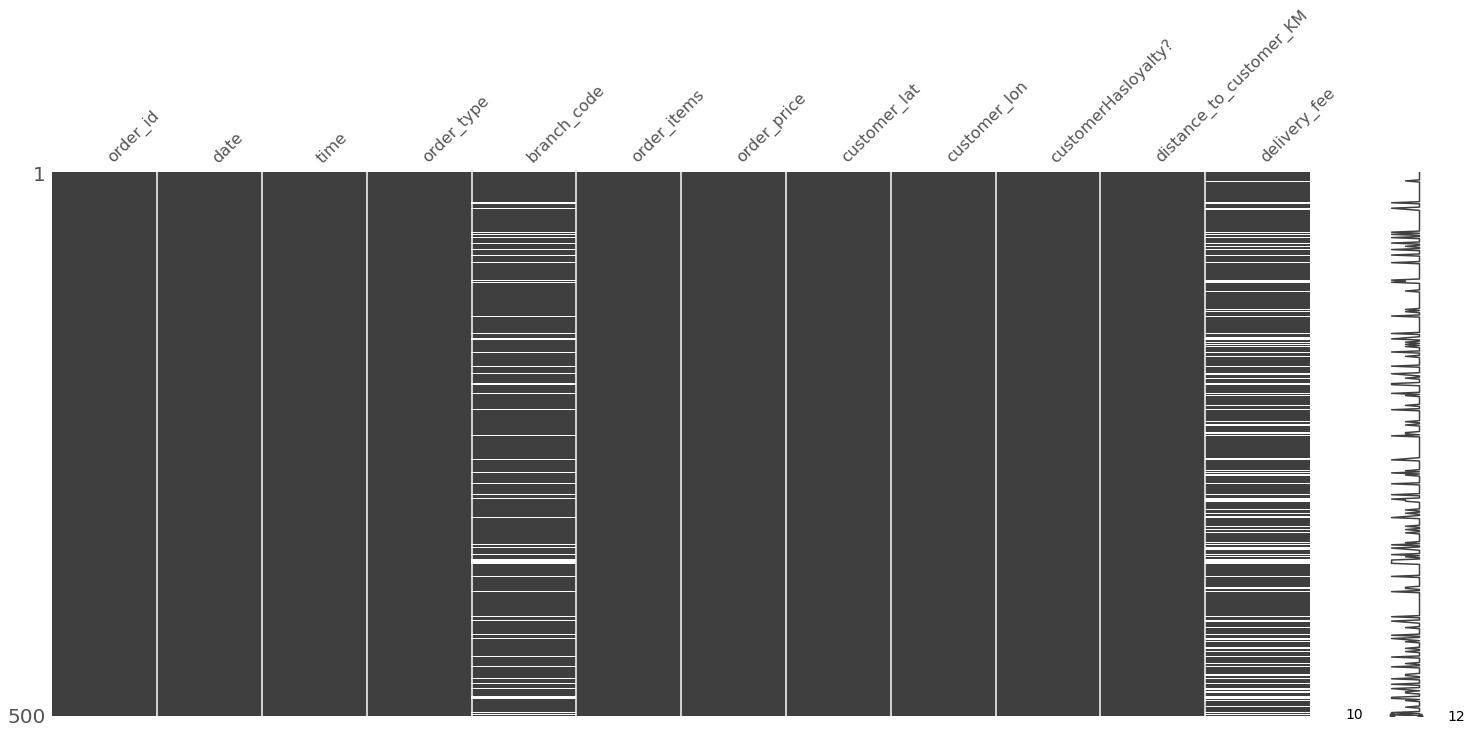

In [325]:
msno.matrix(df =missing_data)

The above charts display potential issues in the `branch_code` and `delivery_fee` fields

#### Branch Code

In order to find the best possible value to fill in the missing branch codes, we will print the head values of the data frame to find associated variables:

In [326]:
missing_data.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDB03023,2021-09-09,16:16:54,Dinner,TP,"[('Salmon', 6), ('Pasta', 1), ('Fish&Chips', 1)]",308.5,-37.811774,145.002000,0,11.108,15.675114
1,ORDX01158,2021-08-11,15:16:03,Lunch,BK,"[('Burger', 5), ('Fries', 7)]",239.0,-37.800240,144.984491,0,6.440,12.266605
2,ORDJ01203,2021-01-17,08:30:25,Breakfast,TP,"[('Cereal', 5), ('Eggs', 9)]",289.0,-37.817335,144.962208,1,7.904,5.796403
3,ORDY00837,2021-09-13,16:27:02,Dinner,TP,"[('Pasta', 2), ('Salmon', 7)]",342.0,-37.804640,144.971640,0,9.800,13.371503
4,ORDK09018,2021-11-16,18:28:43,Dinner,BK,"[('Salmon', 6), ('Pasta', 4)]",356.0,-37.825059,144.928569,0,15.180,22.281960


It's possible that we could derive the missing branch codes with the `order_id` field, as there seems to be a pattern with the digits:

In [327]:
# create a copy df
missing_data_c = missing_data.copy()
# create new column for the order_id digits
missing_data_c['id_digs'] = missing_data_c['order_id'].str[:4]

In [328]:
missing_data_c[['branch_code','id_digs','order_id']].groupby(['branch_code','id_digs']).count()

order_id
branch_code id_digs          
BK          ORDA           40
            ORDK           68
            ORDX           47
NS          ORDC           53
            ORDI           47
            ORDZ           57
TP          ORDB           49
            ORDJ           44
            ORDY           45

As suspected, each branch code has three different types of order id digits that are unique to that branch. Therefore we will use this logic to fill the null values of `branch_code`. Also, its important to mention that this type of missigness falls under the **"MNAR"** type. To fill in the values, we will filter the dataframe by the new created `id_digs` column, combined with null values on branch code. Lastly, we will simply use the mask created and assign the proper branch code to the selection.

In [329]:
# create a mask of null values for each branch
bk_mask  = ((missing_data_c['id_digs'] == 'ORDA') | (missing_data_c['id_digs'] == 'ORDK') | (missing_data_c['id_digs'] == 'ORDX')) & missing_data_c['branch_code'].isnull()
ns_mask  = ((missing_data_c['id_digs'] == 'ORDC') | (missing_data_c['id_digs'] == 'ORDI') | (missing_data_c['id_digs'] == 'ORDZ')) & missing_data_c['branch_code'].isnull()
tp_mask  = ((missing_data_c['id_digs'] == 'ORDB') | (missing_data_c['id_digs'] == 'ORDJ') | (missing_data_c['id_digs'] == 'ORDY')) & missing_data_c['branch_code'].isnull()
# re assign values by using the mask
missing_data_c.loc[bk_mask,'branch_code'] = "BK"
missing_data_c.loc[ns_mask,'branch_code'] = "NS"
missing_data_c.loc[tp_mask,'branch_code'] = "TP"

#### Delivery Fee

In [330]:
# from statsmodels.formula.api import ols
# from scipy import stats
# import statsmodels.api as sm
# from statsmodels.sandbox.regression.predstd import wls_prediction_std
# method 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression

In [331]:
lm = LinearRegression

Based on the assignment brief, we will need to create dummy variables to be used in a linear regression based on the following aspects of the data:
1. is_weekend = 1 if the day of the order is Saturday or Sunday, or 0 otherwise.
2. is_morning = 0 if morning, 1 for afternoon and 2 for evening.

Also, it's important to note that customers that are part of the loyalty program get a 50% discount, distance needs to be considered and each branch has it's own delivery fee calculation.

Firstly, we will create masks to segment the data based on Branch:

In [332]:
# create a branch code and null delivery fee mask and non-null variables
fee_bk_mask = (missing_data_c['branch_code'] == 'BK') & (missing_data_c['delivery_fee'].notna())
fee_ns_mask = (missing_data_c['branch_code'] == 'NS') & (missing_data_c['delivery_fee'].notna())
fee_tp_mask = (missing_data_c['branch_code'] == 'TP') & (missing_data_c['delivery_fee'].notna())

Next, we need to create dummy variables that will allow us to run a regression on categorical variables.

##### Delivery Fee dummy variables

We will create a dummy variable for the day of the week contained in `date` by using a simple pandas filtering, and assigning the value of one or zero.

In [333]:
# change date datatype to datetime
missing_data_c['date'] = pd.to_datetime(missing_data_c["date"])
#create new empty variable
missing_data_c['is_weekend'] = np.nan
# assign value based on the weekday
missing_data_c.loc[missing_data_c.date.dt.weekday >= 5, 'is_weekend'] = 1
missing_data_c.loc[missing_data_c.date.dt.weekday < 5, 'is_weekend'] = 0

In [334]:
#is_morning
order_dummies = pd.get_dummies(missing_data_c.order_type, drop_first=True, prefix='order_type')

In [335]:
#overwritting the dataset with the appended extra column.
missing_data_c = pd.concat([missing_data_c,order_dummies], axis=1)

We also need to convert the delivery fee price of loyalty cutomers:

In [336]:
#multiply the delivery fee of customers part of loyalty group
missing_data_c['delivery_fee2'] = missing_data_c.delivery_fee.where(missing_data_c['customerHasloyalty?'] == 0, missing_data_c.delivery_fee * 2 )

With the last transformation above we've now created all the necessary variables are ready to be used in a linear regression model.

We only need some of the variables to be included in the model. Therefore, first we will slice the original copy into a version with fewer columns:

In [337]:
#test without the converted delivery fee:

# slicing the model
missing_data_c_ls = missing_data_c.iloc[:,9:]
# dropping unn
missing_data_c_ls.drop(columns=['id_digs','delivery_fee2'], axis=1, inplace=True)
# looking at the first observations
missing_data_c_ls.head()

,customerHasloyalty?,distance_to_customer_KM,delivery_fee,is_weekend,order_type_Dinner,order_type_Lunch
0,0,11.108,15.675114,0.0,1,0
1,0,6.440,12.266605,0.0,0,1
2,1,7.904,5.796403,1.0,0,0
3,0,9.800,13.371503,0.0,1,0
4,0,15.180,22.281960,0.0,1,0


For X, we will keep all the variables except `delivery_fee`, as that is the dependent variable.

Now that we have all the variables ready, we can create a linear regression on each branch subset with the `statsmodels` library.

##### Delivery Fee linear regression: BK branch

In [377]:
# assigning variables
X = missing_data_c_ls.loc[fee_bk_mask,:].drop('delivery_fee', axis=1)
y = missing_data_c_ls.loc[fee_bk_mask,:].delivery_fee

In [378]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
#creating and training the model
from sklearn.linear_model import LinearRegression
#instantiate model
lm = LinearRegression()
# train model
lm.fit(X_train,y_train)

LinearRegression()

In [379]:
#printing the coefficients
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
customerHasloyalty?,-7.137912
distance_to_customer_KM,1.040017
is_weekend,2.477344
order_type_Dinner,1.890530
order_type_Lunch,1.093601


In [380]:
print ('r-squared for this model = ',lm.score(X_test,y_test))

r-squared for this model =  0.9863619182167275


##### Delivery Fee linear regression: NS branch

In [223]:
# assigning variables
X = missing_data_c_ls.loc[fee_ns_mask,:].drop('delivery_fee', axis=1)
y = missing_data_c_ls.loc[fee_ns_mask,:].delivery_fee

In [367]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
#creating and training the model
from sklearn.linear_model import LinearRegression
#instantiate model
lm = LinearRegression()
# train model
lm.fit(X_train,y_train)

LinearRegression()

In [368]:
#printing the coefficients
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
customerHasloyalty?,-7.137912
distance_to_customer_KM,1.040017
is_weekend,2.477344
order_type_Dinner,1.890530
order_type_Lunch,1.093601


In [369]:
print ('r-squared for this model = ',lm.score(X_test,y_test))

r-squared for this model =  0.9863619182167275


##### Delivery Fee linear regression: TP

In [370]:
# assigning variables
X = missing_data_c_ls.loc[fee_tp_mask,:].drop('delivery_fee', axis=1)
y = missing_data_c_ls.loc[fee_tp_mask,:].delivery_fee

In [374]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
#creating and training the model
from sklearn.linear_model import LinearRegression
#instantiate model
lm = LinearRegression()
# train model
lm.fit(X_train,y_train)

LinearRegression()

In [375]:
#printing the coefficients
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
customerHasloyalty?,-5.892718
distance_to_customer_KM,0.873128
is_weekend,1.331643
order_type_Dinner,1.478950
order_type_Lunch,0.836204


In [376]:
print ('r-squared for this model = ',lm.score(X_test,y_test))

r-squared for this model =  0.9925413909162757


##### Delivery Fee: Using the regression model results

In [234]:
# add some code

### Outlier Data

## Summary <a class="anchor" name="summary"></a>

In conclussion, this excercise has covered all the necessary steps required to process semi-structured files into a unified dataframe that is adequate for analysis.
<br>
The key steps of the process undoubtedly lie on understanding the structure of the information to be structured. In this case, the data was formatted in HTML and hence it wasn't too difficult to design regular expressions that could extract the right type of information.
<br>
With the right regular expression design, the data was extracted using simple loops to store the data into a format that is efficient to parse (in this case, a list). Lastly, the pandas library was extremely helpful in structuring the data in a tabular format that can then be examined.

-------------------------------------

## References <a class="anchor" name="Ref"></a>




[1]<a class="anchor" name="ref-2"></a> Why do I need to add DOTALL to python regular expression to match new line in raw string, https://stackoverflow.com/questions/22610247, Accessed 30/08/2022.


https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
....


https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

dummy variables in pandas
<br>
https://www.youtube.com/watch?v=0s_1IsROgDc

regression summary
<br>
https://www.statology.org/sklearn-linear-regression-summary/

--------------------------------------------------------------------------------------------------------------------------